In [2]:
from keras.layers import Dense, LSTM, Embedding, Flatten
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from sklearn.model_selection import train_test_split
import gzip
import pandas as pd

VarParameter="category_code"
VarParameter2="category"
def get_val(numerator,divisor):
    return float('nan') if divisor == 0 else np.round(numerator/divisor,3)
from collections import defaultdict
def analyze_predictions(categories, y_true, y_pred):
    tp = defaultdict(int)
    tn = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    precisions = []
    recalls = []
    f1s = []
    cat_counts = defaultdict(int)
    for cat in y_true:
        cat_counts[cat] += 1
    correct = 0
    conf_mat = defaultdict(dict)
    for cat1 in categories:
        for cat2 in categories:
            conf_mat[cat1][cat2] = 0
    for y, y_hat in zip(y_true, y_pred):
        conf_mat[y][y_hat] += 1
        if y == y_hat:
            correct += 1
            tp[y] += 1
        else:
            fp[y_hat] += 1
            fn[y] += 1
    print('Overall Accuracy:', round(correct / len(y_pred), 3))
    for cat in categories:
        precision = get_val(tp[cat], tp[cat] + fp[cat])
        recall = get_val(tp[cat], (tp[cat] + fn[cat]))
        f1 = get_val(2 * precision * recall, precision + recall)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        print('{} --> Precision:{},Recall:{},F1:{}'.format(cat, precision, recall, f1))
    print('\nAverages---> Precision:{}, Recall:{}, F1:{}'.format(np.round(np.nanmean(precisions), 3),
                                                                 np.round(np.nanmean(recalls), 3),
                                                                 np.round(np.nanmean(f1s), 3))
          )

    print('\nConfusion Matrix')
    for cat1 in categories:
        print('\n' + str(cat1) + '({}) --> '.format(cat_counts[cat1]), end='')
        for cat2 in categories:
            print('{}({})'.format(cat2, conf_mat[cat1][cat2]), end=' , ')
    print('')


def one_hot_to_category(cat_one_hot_list,cat_master):
    return [cat_master[cat_one_hot.argmax()] for cat_one_hot in cat_one_hot_list]

# From Deep Learning with Python book
def make_history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='green',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
# Build the keras model
def build_model(embedding_matrix,categories):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
    return model

def build_model2(embedding_matrix,categories):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
    return model

def get_embedding(word,word_index,embeddings):
    if word in word_index:
        return embeddings[word_index[word]].reshape(((embedding_size,1)))
    else:
        return np.zeros((embedding_size,1))
# Get the embedding weights for the model
def get_embedding_matrix_for_model(embeddings,word_index):
    train_val_words = min(vocab_size, len(word_index)) +1
    embedding_matrix = np.zeros((train_val_words, embedding_size))
    for word, i in word_index.items():
        embedding_vector = get_embedding(word,word_index,embeddings).flatten()
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
# Common methods to read data and get embeddings
def read_data():
    df_train = train
    df_val = test
    categories = list(set(df_train.categories.values))
    return df_train,df_val,categories

def read_data2():
    df_train = train
    df_val = test
    #categories = list(set(df_train.categories.values))
    categories = list(set(dfdrugbank2[VarParameter].values))
    #categories = list(set(df.cat2id.values))
    return df_train,df_val,categories

def load_embeddings():
    word_index = {}
    embeddings = np.zeros((vocab_size,embedding_size))
    with gzip.open(embeddings_path) as file:
        for i,line in enumerate(file):
            line_tokens = line.split()
            word = line_tokens[0].decode('utf8')
            embeddings[i] = np.asarray(line_tokens[1:],dtype='float32')
            word_index[word] = i
    return embeddings,word_index

def prepare_data_from_full_word_index(df_train,df_val,categories,word_index):
    train_text = df_train['description'].tolist()
    val_text = df_val['description'].tolist()
    x_train = get_pad_sequences(train_text,word_index)
    x_val = get_pad_sequences(val_text,word_index)
    y_train = category_to_one_hot(df_train['categories'].values,categories)
    y_val = category_to_one_hot(df_val['categories'].values,categories)
    return word_index,x_train,y_train,x_val,y_val

#df_train,df_val,categories = read_data2()
#Load Glove 50-d embeddings
#embeddings,word_index = load_embeddings()
#tk_word_index,x_train,y_train,x_val,y_val = prepare_data_from_full_word_index2(df_train,df_val,categories,word_index)

def prepare_data_from_full_word_index2(df_train,df_val,categories,word_index):
    train_text = df_train['description'].tolist()
    val_text = df_val['description'].tolist()
    x_train = get_pad_sequences(train_text,word_index)
    x_val = get_pad_sequences(val_text,word_index)
    y_train = category_to_one_hot(df_train[VarParameter].values,categories)
    #y_train = df_train['cat2id']
    #y_val = df_val['cat2id']
    y_val = category_to_one_hot(df_val[VarParameter].values,categories)

    #data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    #labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', x_train.shape)
    print('Shape of label tensor:', y_train.shape)    
    
    return word_index,x_train,y_train,x_val,y_val


# Convert the list of categories to one_hot vector
def category_to_one_hot(cat_list,cat_master):
    cat_dict = {}
    for i,cat in enumerate(cat_master):
        cat_dict[cat] = i
    cat_integers = [cat_dict[cat] for cat in cat_list]
    return to_categorical(cat_integers,num_classes=len(cat_master))


def get_pad_sequences(text_list,word_index):
    seqs = []
    for text in text_list:
        word_seq = text_to_word_sequence(text.lower())
        seq = []
        for word in word_seq:
          if word in word_index:
            seq.append(word_index[word])
        seqs.append(seq)
    return pad_sequences(seqs,maxlen)

def category_to_id(cat_desc):
    catidx=None
    for id,val in enumerate(cat_desc):
#        print(id,val)
        catidx=catlist2.index(val)
#        print(catidx)
    return (catidx)



In [3]:
import time
import sys,os
import os
Homedir = os.getcwd()


dfdrugbank=pd.read_csv("C:/git/DMPrj/data/drugbank.tsv",delimiter="\t")
dfprotein=pd.read_csv("C:/git/DMPrj/data/proteins.tsv",delimiter="\t")
dfdrugbank['DrugBank_id']=dfdrugbank['drugbank_id']
dfprotein['DrugBank_id']=dfprotein['drugbank_id']
dfnodes=pd.read_csv("C:/git/DMPrj/data/DrugBank_DDI/node_list.txt",delimiter="	")
dfnodes['ID']=dfnodes.index
dfdrugbank2=dfdrugbank.merge(dfnodes,how="left",on="DrugBank_id")
dfdrugbank2=dfdrugbank.merge(dfprotein,how="left",on="DrugBank_id")
dfdrugbank2.dropna(inplace=True)

#dfdrugbank2 = dfdrugbank2[dfdrugbank2['organism']!='Human']
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
dfdrugbank2["category_code"] = lb_make.fit_transform(dfdrugbank2["category"])
dfdrugbank2["actions_code"] = lb_make.fit_transform(dfdrugbank2["actions"])
dfdrugbank2["organism_code"] = lb_make.fit_transform(dfdrugbank2["organism"])
dfdrugbank2["groups_code"] = lb_make.fit_transform(dfdrugbank2["groups"])
dfdrugbank2["type_code"] = lb_make.fit_transform(dfdrugbank2["type"])



df = dfdrugbank2[pd.notnull(dfdrugbank2['description'])]
df = df[pd.notnull(df['description'])]
train, test  = train_test_split( df, test_size=0.20, random_state=10)


In [7]:
vocab_size = 400000
embedding_size = 50
maxlen = 1000
embeddings_path = 'C:/git/DMPrj/embeddings/glove.6B.50d.txt.gz'
import numpy as np

df_train,df_val,categories = read_data2()
#Load Glove 50-d embeddings
embeddings,word_index = load_embeddings()
tk_word_index,x_train,y_train,x_val,y_val = prepare_data_from_full_word_index2(df_train,df_val,categories,word_index)

# Get the embedding matrix for the model, build model, display model summary
embedding_matrix = get_embedding_matrix_for_model(embeddings,word_index)
model = build_model(embedding_matrix,categories)

Shape of data tensor: (5696, 1000)
Shape of label tensor: (5696, 4)


Train on 5696 samples, validate on 1425 samples
Epoch 1/50
5696/5696 [==============================] - 107s 19ms/step - loss: 1.0376 - acc: 0.4944 - val_loss: 1.0059 - val_acc: 0.4996
Epoch 2/50
5696/5696 [==============================] - 113s 20ms/step - loss: 0.9814 - acc: 0.5223 - val_loss: 0.9894 - val_acc: 0.5137
Epoch 3/50
5696/5696 [==============================] - 112s 20ms/step - loss: 0.9502 - acc: 0.5418 - val_loss: 0.9703 - val_acc: 0.5418
Epoch 4/50
5696/5696 [==============================] - 121s 21ms/step - loss: 0.9216 - acc: 0.5648 - val_loss: 0.9492 - val_acc: 0.5572
Epoch 5/50
5696/5696 [==============================] - 118s 21ms/step - loss: 0.8944 - acc: 0.5846 - val_loss: 0.9385 - val_acc: 0.5600
Epoch 6/50
5696/5696 [==============================] - 111s 19ms/step - loss: 0.8718 - acc: 0.6001 - val_loss: 0.9415 - val_acc: 0.5677
Epoch 7/50
5696/5696 [==============================] - 118s 21ms/step - loss: 0.8531 - acc: 0.6155 - val_loss: 0.9453 - val_acc: 

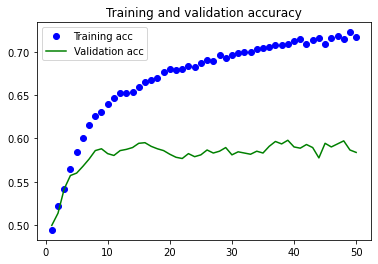

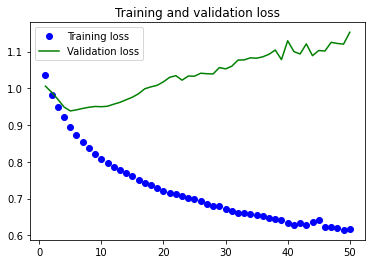

In [8]:
# Train the model, record history
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=24,
                    shuffle=False,
                    validation_data=(x_val, y_val))


import matplotlib.pyplot as plt
make_history_plot(history)


In [11]:
# Make and analyze training predictions
train_predictions = one_hot_to_category(model.predict(x_train),categories)
analyze_predictions(categories,df_train[VarParameter].values,train_predictions)



Overall Accuracy: 0.665
0 --> Precision:nan,Recall:0.0,F1:nan
1 --> Precision:0.585,Recall:0.644,F1:0.613
2 --> Precision:0.731,Recall:0.792,F1:0.76
3 --> Precision:0.604,Recall:0.348,F1:0.442

Averages---> Precision:0.64, Recall:0.446, F1:0.605

Confusion Matrix

0(28) --> 0(0) , 1(8) , 2(16) , 3(4) , 
1(1895) --> 0(0) , 1(1220) , 2(584) , 3(91) , 
2(2827) --> 0(0) , 1(466) , 2(2240) , 3(121) , 
3(946) --> 0(0) , 1(393) , 2(224) , 3(329) , 


In [10]:
# Make and analyze validation predictions
val_predictions = one_hot_to_category(model.predict(x_val),categories)
analyze_predictions(categories,df_val[VarParameter].values,val_predictions)

Overall Accuracy: 0.584
0 --> Precision:nan,Recall:0.0,F1:nan
1 --> Precision:0.511,Recall:0.581,F1:0.544
2 --> Precision:0.658,Recall:0.701,F1:0.679
3 --> Precision:0.476,Recall:0.254,F1:0.331

Averages---> Precision:0.548, Recall:0.384, F1:0.518

Confusion Matrix

0(4) --> 0(0) , 1(0) , 2(3) , 3(1) , 
1(501) --> 0(0) , 1(291) , 2(174) , 3(36) , 
2(688) --> 0(0) , 1(178) , 2(482) , 3(28) , 
3(232) --> 0(0) , 1(100) , 2(73) , 3(59) , 


In [12]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
train_predictions
#plot_confusion_matrix(clf, X_test, y_test)  # doctest: +SKIP

confusion_matrix(df_train[VarParameter].values, train_predictions)

array([[   0,    8,   16,    4],
       [   0, 1220,  584,   91],
       [   0,  466, 2240,  121],
       [   0,  393,  224,  329]], dtype=int64)

(11590, 5)

In [14]:
texts =  dfdrugbank2['description'].values# list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = dfdrugbank2[VarParameter].values
#for row in dfdrugbank2.index:
#    texts.append(row['description'])
#    labels.append(row['category_code'])
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
dfdrugbank2[VarParameter] = lb_make.fit_transform(dfdrugbank2[VarParameter2])
category_index={}
for i in list(set(dfdrugbank2[VarParameter])):
    labels_index[i]=list(set(dfdrugbank2[VarParameter2]))[i]
#category_index[dfdrugbank2["category"]] = dfdrugbank2["category_code"]
print(labels_index)

{0: 'transporter', 1: 'carrier', 2: 'enzyme', 3: 'target'}


In [15]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant


MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 400000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

#vocab_size = 400000
#embedding_size = 50
#maxlen = 10

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


Found 6686 unique tokens.
Shape of data tensor: (7121, 1000)
Shape of label tensor: (7121, 4)


In [16]:
embeddings_index = {}
embeddings_path = r'C:\\git\\DMPrj\\embeddings\\glove.6B.50d.txt'
f = open(embeddings_path,encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [166]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=50, batch_size=128)



Train on 5697 samples, validate on 1424 samples
Epoch 1/50
5697/5697 [==============================] - 38s 7ms/step - loss: 1.0632 - acc: 0.4792 - val_loss: 1.0822 - val_acc: 0.4895
Epoch 2/50
5697/5697 [==============================] - 38s 7ms/step - loss: 1.0370 - acc: 0.4939 - val_loss: 1.0622 - val_acc: 0.4895
Epoch 3/50
5697/5697 [==============================] - 36s 6ms/step - loss: 1.0277 - acc: 0.4971 - val_loss: 1.0285 - val_acc: 0.4895
Epoch 4/50
5697/5697 [==============================] - 32s 6ms/step - loss: 0.9934 - acc: 0.5099 - val_loss: 1.0087 - val_acc: 0.4895
Epoch 5/50
5697/5697 [==============================] - 32s 6ms/step - loss: 0.9519 - acc: 0.5366 - val_loss: 1.0609 - val_acc: 0.5021
Epoch 6/50
5697/5697 [==============================] - 31s 6ms/step - loss: 0.9250 - acc: 0.5636 - val_loss: 0.9591 - val_acc: 0.5597
Epoch 7/50
5697/5697 [==============================] - 32s 6ms/step - loss: 0.8975 - acc: 0.5815 - val_loss: 1.1127 - val_acc: 0.5133
Epoch 8

Train on 5697 samples, validate on 1424 samples
Epoch 1/50
5697/5697 [==============================] - 41s 7ms/step - loss: 0.7096 - acc: 0.6730 - val_loss: 0.9818 - val_acc: 0.6173
Epoch 2/50
5697/5697 [==============================] - 43s 8ms/step - loss: 0.7030 - acc: 0.6737 - val_loss: 1.0886 - val_acc: 0.6166
Epoch 3/50
5697/5697 [==============================] - 40s 7ms/step - loss: 0.6976 - acc: 0.6772 - val_loss: 1.0760 - val_acc: 0.6194
Epoch 4/50
5697/5697 [==============================] - 40s 7ms/step - loss: 0.6913 - acc: 0.6784 - val_loss: 1.3097 - val_acc: 0.6124
Epoch 5/50
5697/5697 [==============================] - 42s 7ms/step - loss: 0.6845 - acc: 0.6837 - val_loss: 1.5944 - val_acc: 0.5927
Epoch 6/50
5697/5697 [==============================] - 39s 7ms/step - loss: 0.6849 - acc: 0.6811 - val_loss: 1.3739 - val_acc: 0.6032
Epoch 7/50
5697/5697 [==============================] - 43s 7ms/step - loss: 0.6718 - acc: 0.6854 - val_loss: 1.3889 - val_acc: 0.5948
Epoch 8

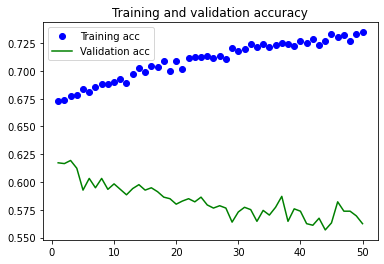

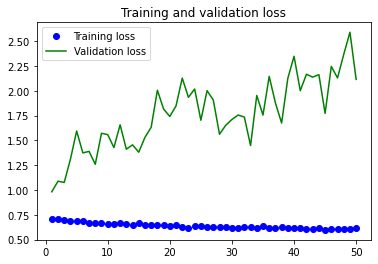

In [21]:
# Train the model, record history
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=24,
                    shuffle=False,
                    validation_data=(x_val, y_val))
import matplotlib.pyplot as plt
make_history_plot(history)


In [ ]:
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])



In [169]:
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], 50, weights=[embedding_matrix],input_length=1000,trainable=False))
model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(labels_index), activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128)


Train on 361 samples, validate on 90 samples
Epoch 1/10
361/361 [==============================] - 6s 16ms/step - loss: 1.0849 - acc: 0.4598 - val_loss: 0.9533 - val_acc: 0.9778
Epoch 2/10
361/361 [==============================] - 4s 12ms/step - loss: 0.8936 - acc: 0.9889 - val_loss: 0.7904 - val_acc: 0.9778
Epoch 3/10
361/361 [==============================] - 4s 12ms/step - loss: 0.7247 - acc: 0.9917 - val_loss: 0.6256 - val_acc: 0.9778
Epoch 4/10
361/361 [==============================] - 4s 12ms/step - loss: 0.5553 - acc: 0.9917 - val_loss: 0.4673 - val_acc: 0.9778

In [82]:
# Train the model, record history

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
# Make and analyze training predictions
train_predictions = one_hot_to_category(model.predict(x_train),categories)
analyze_predictions(categories,df_train[VarParameter].values,train_predictions)

Overall Accuracy: 0.406
0 --> Precision:0.0,Recall:0.0,F1:nan
1 --> Precision:0.336,Recall:0.328,F1:0.332
2 --> Precision:0.503,Recall:0.551,F1:0.526
3 --> Precision:0.182,Recall:0.144,F1:0.161

Averages---> Precision:0.255, Recall:0.256, F1:0.34

Confusion Matrix

0(28) --> 0(0) , 1(8) , 2(16) , 3(4) , 
1(1895) --> 0(1) , 1(622) , 2(1028) , 3(244) , 
2(2827) --> 0(1) , 1(905) , 2(1557) , 3(364) , 
3(946) --> 0(0) , 1(318) , 2(492) , 3(136) , 


In [23]:
# Make and analyze validation predictions
val_predictions = one_hot_to_category(model.predict(x_val),categories)
analyze_predictions(categories,df_val[VarParameter].values,val_predictions)



Overall Accuracy: 0.41
0 --> Precision:0.0,Recall:0.0,F1:nan
1 --> Precision:0.364,Recall:0.324,F1:0.343
2 --> Precision:0.498,Recall:0.57,F1:0.532
3 --> Precision:0.157,Recall:0.129,F1:0.142

Averages---> Precision:0.255, Recall:0.256, F1:0.339

Confusion Matrix

0(4) --> 0(0) , 1(2) , 2(1) , 3(1) , 
1(501) --> 0(1) , 1(162) , 2(264) , 3(73) , 
2(688) --> 0(0) , 1(209) , 2(392) , 3(87) , 
3(232) --> 0(0) , 1(72) , 2(130) , 3(30) , 


Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 451 texts.
Found 1295 unique tokens.
Shape of data tensor: (451, 1000)
Shape of label tensor: (451, 3)
Preparing embedding matrix.
Training model.

Train on 361 samples, validate on 90 samples
Epoch 1/10
361/361 [==============================] - 3s 8ms/step - loss: 0.4651 - acc: 0.8809 - val_loss: 0.0833 - val_acc: 0.9889
Epoch 2/10
361/361 [==============================] - 3s 8ms/step - loss: 0.1712 - acc: 0.9889 - val_loss: 0.0674 - val_acc: 0.9889
Epoch 3/10
361/361 [==============================] - 3s 7ms/step - loss: 0.0837 - acc: 0.9889 - val_loss: 0.0751 - val_acc: 0.9889